[This dataset](https://daac.ornl.gov/VEGETATION/guides/Land_Use_Harmonization_V2.html) provides 0.25-degree gridded, global, annual estimates of fractional land use and land cover patterns for the period 2015-2100, designed to support the ISIMIP2b effort to assess the impacts of 1.5 Deg Celsius global warming. Land use types, land use transitions, and cropland estimates of area fraction are provided.

The LUH2-ISIMIP2b datasets were derived using Land Use Harmonization 2 (LUH2) methodology and are based on land-use scenarios provided by the REMIND-MAgPIE Integrated Assessment Model using an SSP2 storyline along with RCP2.6 and RCP6.0 emissions scenarios.

There are 24 data files in NetCDF version 4 (.nc4) format with this dataset, including three files for each of four models employing two emission scenarios.

The 'Data variables' listed below are the ones we are interested in.
Each of them represents a different land cover type.

The values are the fraction of the land that is covered by that land cover type.
The values are between 0 and 1, and they are the same for each year. They should all add up to 1.

The land cover types are:
primf - forested primary land
secdf - potentially forested secondary land
secdn - potentially non-forested secondary land
primn - non-forested primary land
pastr - managed pasture
range - rangeland
c3ann - C3 annual crops
c3per - C3 perennial crops
c4ann - C4 annual crops
c4per - C4 perennial crops
c3nfx - C3 nitrogen-fixing crops
urban - urban land

I would like to combine them into 3 categories: forest, agriculture, and urban.

The script below plots the data globally and within a cropped area.
For our purposes, we need to export each land cover class in the dataset to a geotiff file for processing using the landcover_demand_estimation.py script.
The process should encode each of the land cover classes as a band in a multiband raster, for compatibility with landcover_demand_estimation.py

HOWEVER, if there is a better method of encoding and performing the calculations that would make this more cloud-friendly, let's try to do that instead.

The demand estimation calculations should be done according to the following diagram:
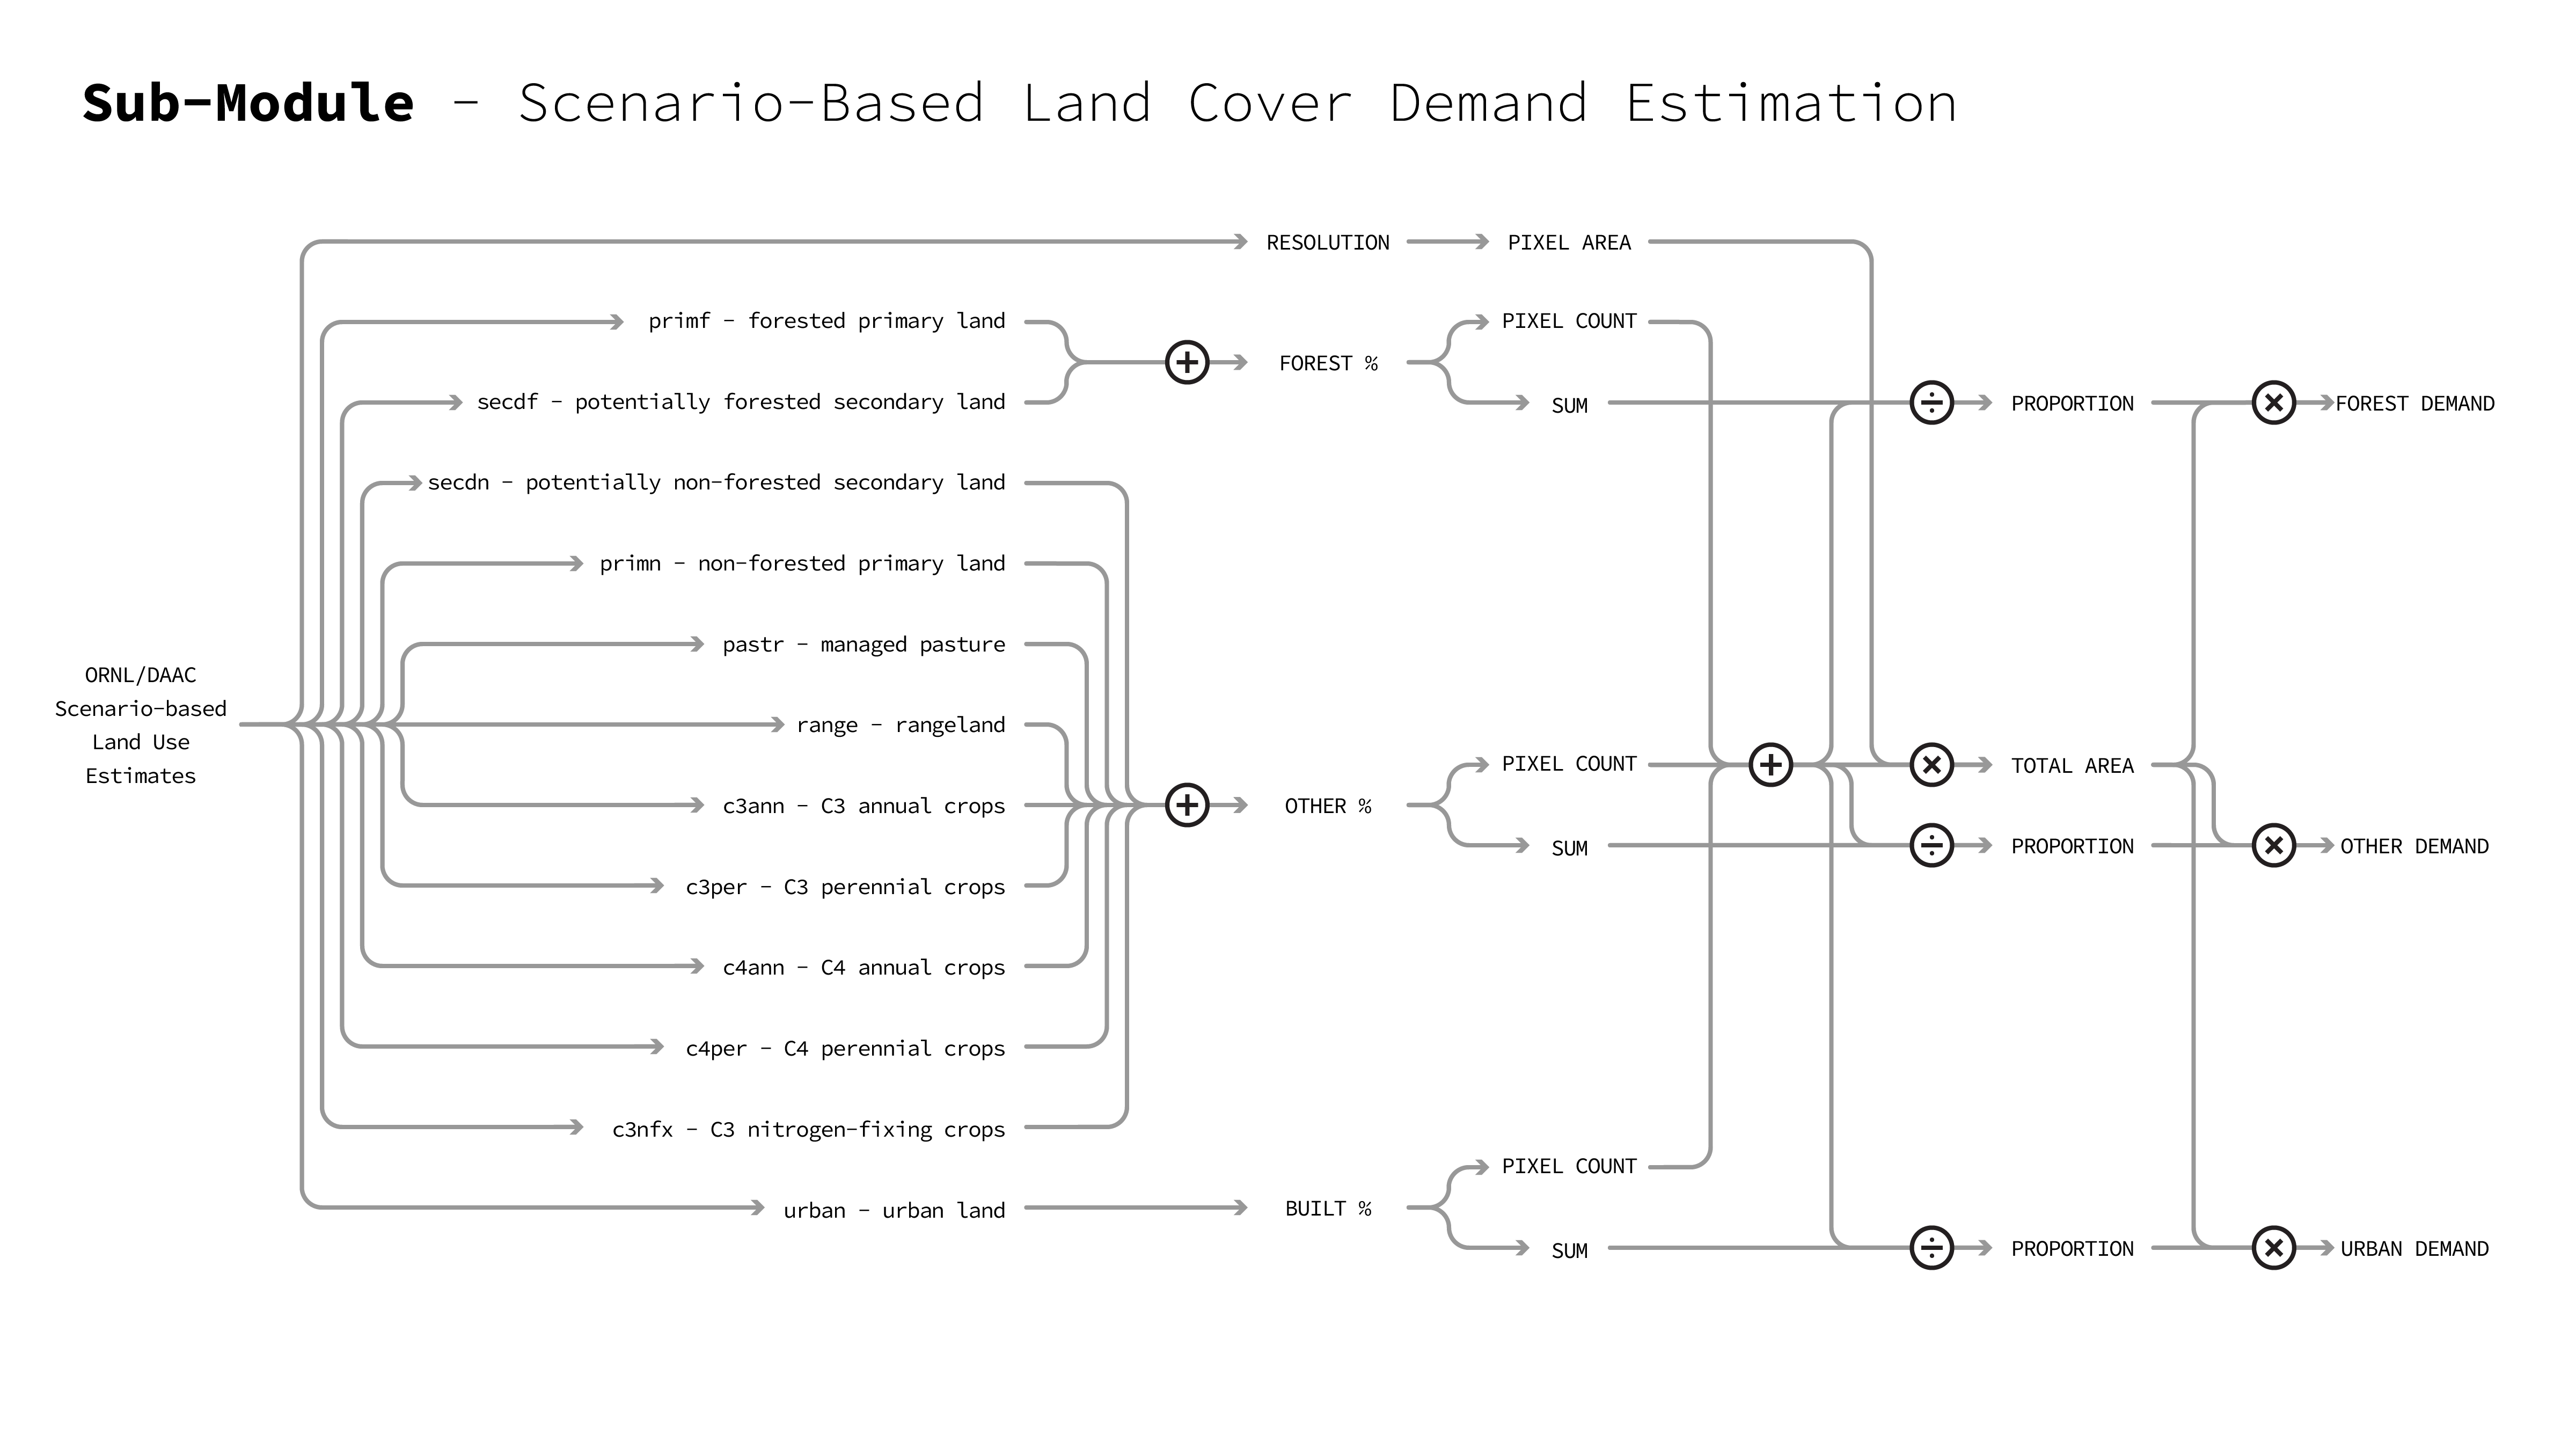

The post challenging part of this will be figuring out how to deal with fractional cells when we do the calculations.

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import geopandas as gpd
import rioxarray
import json

In [53]:
# Load .nc4 file
dataset = xr.open_dataset('G:/RESEARCH/DATA/Global/Land_Use_Harmonization_V2_1721/Land_Use_Harmonization_V2_1721/data/RCP26_GFDL_states.nc4')

# To see the structure of the file, print the dataset
print(dataset)

<xarray.Dataset>
Dimensions:  (time: 86, lat: 720, lon: 1440)
Coordinates:
  * time     (time) object 2015-01-01 00:00:00 ... 2100-01-01 00:00:00
  * lat      (lat) float64 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables: (12/15)
    primf    (time, lat, lon) float32 ...
    primn    (time, lat, lon) float32 ...
    secdf    (time, lat, lon) float32 ...
    secdn    (time, lat, lon) float32 ...
    urban    (time, lat, lon) float32 ...
    c3ann    (time, lat, lon) float32 ...
    ...       ...
    c3nfx    (time, lat, lon) float32 ...
    pastr    (time, lat, lon) float32 ...
    range    (time, lat, lon) float32 ...
    secmb    (time, lat, lon) float32 ...
    secma    (time, lat, lon) float32 ...
    crs      |S1 ...
Attributes: (12/23)
    host:                    UMD College Park
    comment:                 LUH2
    contact:                 gchurtt@umd.edu, lchini@umd.edu, steve.frolkin

In [54]:
# Specify the land use variable (this would probably be a good to loop throuh all the land cover variables listed above)
land_use = 'primf'

# Specify the year as a string
year = '2050'

# Concatenate to form the full datetime string
datetime = f'{year}-01-01 00:00:00'


In [55]:
# Load crop data from github
# URL of the GeoJSON file
url = 'https://raw.githubusercontent.com/HotspotStoplight/HotspotStoplight/main/CropBoxes/CR_Crop1.geojson'

# Fetch the GeoJSON content from the URL
response = requests.get(url)
geojson_data = response.json()

# Assuming the first feature's geometry contains the rectangle
# Check if the GeoJSON is structured as a FeatureCollection
if geojson_data['type'] == 'FeatureCollection':
    # Assuming we're interested in the first feature's geometry
    # and it's a Polygon
    coordinates = geojson_data['features'][0]['geometry']['coordinates'][0]
else:
    # If not a FeatureCollection, directly access the geometry (adjust as needed)
    coordinates = geojson_data['geometry']['coordinates'][0]

# Extract latitudes and longitudes
lats, lons = zip(*coordinates)

# Find min and max for latitude and longitude
min_lat, max_lat = min(lats), max(lats)
min_lon, max_lon = min(lons), max(lons)

# Create slices
lon_range = slice(min_lat, max_lat)  # From min to max longitude
lat_range = slice(min_lon, max_lon)  # From min to max latitude

# Print the slices
print(f"Latitude range: {lat_range}")
print(f"Longitude range: {lon_range}")


Latitude range: slice(5.516416423420095, 13.701056321163325, None)
Longitude range: slice(-91.62335850740233, -76.87422516816252, None)


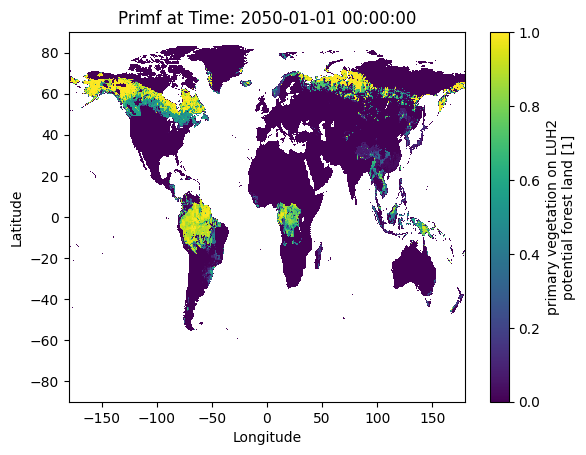

In [56]:
# Use .sel with the created string to select the desired time step
data = dataset[land_use].sel(time=datetime)

data.plot()
plt.title(f'{land_use.capitalize()} at Time: {datetime}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


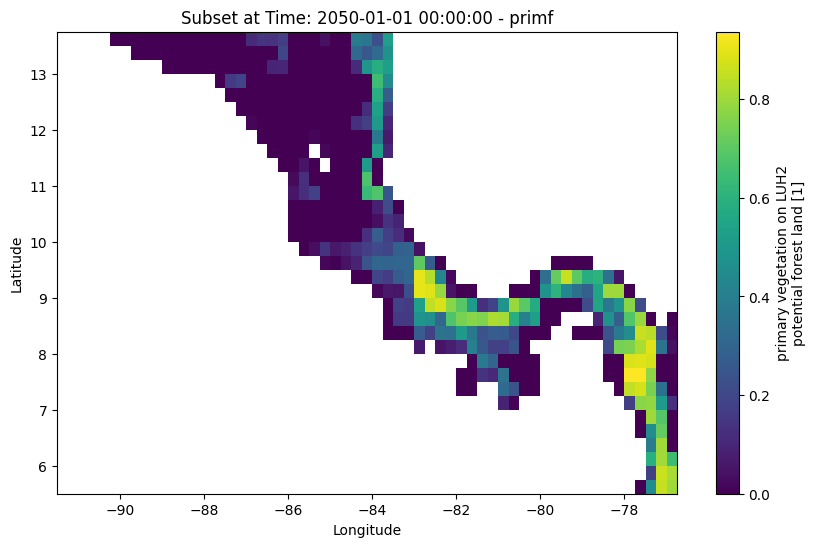

In [57]:
# Crop and plot
primf_subset = dataset[land_use].sel(time=datetime, lat=lat_range, lon=lon_range)

plt.figure(figsize=(10, 6))
primf_subset.plot()
plt.title(f'Subset at Time: {datetime} - {land_use}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



In [58]:
# Extract data and export to geotiff
# Select the desired time step
# Ensure that your dataset's time format matches this selection method
data = dataset[land_use].sel(time=datetime)

# Export to a GeoTIFF file
output_filepath = 'C:/Users/olive/Documents/GitHub/LandCoverChange/data/ScenarioBased_LC/urban_2024.tif'
data.rio.to_raster(output_filepath)